# Test: Simulate ACA tracking a single star #

In [1]:
from __future__ import division
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from Quaternion import Quat
from astropy.table import Table
import Ska.Numpy
from Ska.engarchive import fetch_sci as fetch
from mica.archive import asp_l1
from mica.archive.aca_l0 import get_l0_images, get_slot_data
from Chandra.Time import DateTime
from Ska.Matplotlib import plot_cxctime
import cxotime
from chandra_aca.aca_image import ACAImage
import chandra_aca.transform as transform
from kadi import events
import mica.starcheck

In [ ]:
# local imports:
import sys
sys.path.append(".")
import aca_simulate as sim
reload(sim)
from aca_simulate import ImgList

In [22]:
def get_telem(cat, slot):
    ok = (cat['slot'] == slot) * ((cat['type'] == 'BOT') + (cat['type'] == 'GUI'))
    yag, zag = cat['yang'][ok][0], cat['zang'][ok][0]
    mag, maxmag = cat['mag'][ok][0], cat['maxmag'][ok][0]
    return yag, zag, mag, maxmag


def as_array(attr, imgs):
    out = np.array([getattr(img, attr) for img in imgs])
    return out


def plot_star(star, c32=True):
    plt.imshow(star, interpolation='none', cmap='hot', vmin = -100, vmax=2300, origin='lower')
    plt.colorbar()
    plt.hlines(np.arange(0.5, 7.5), -0.5, 7.5, colors='y', linestyles='dotted')
    plt.vlines(np.arange(0.5, 7.5), -0.5, 7.5, colors='y', linestyles='dotted')
    if c32:
        c32 = np.array([1, 2, 2, 6, 6, 7, 7, 6, 6, 2, 2, 1, 1]) - 0.5
        r32 = np.array([2, 2, 1, 1, 2, 2, 6, 6, 7, 7, 6, 6, 2]) - 0.5
        plt.plot(c32, r32, '-', lw=2, color='w')
    plt.xlim(-0.5, 7.5)
    plt.ylim(-0.5, 7.5)
    plt.ylabel('Row')
    plt.xlabel('Column')
    plt.title('(ROW0, COL0) = ({:.0f}, {:.0f})'.format(row0, col0))
    return


def plot_set(imgs, start, vmin=-10, vmax=2000, num=4, grid6x6=False):
    for i in np.arange(start, start + num):
        plt.subplot(1, num, i - start + 1)
        plt.imshow(imgs[i], interpolation='none', origin='lower',
                   cmap='hot', vmin=vmin, vmax=vmax)
        if grid6x6:
            plt.hlines(np.arange(0.5, 5.5), -0.5, 5.5, colors='y', linestyles='dotted')
            plt.vlines(np.arange(0.5, 5.5), -0.5, 5.5, colors='y', linestyles='dotted')
        plt.xlabel('Column (px)')
        if i == start:
            plt.ylabel('Row (px)')
    return


def plot_guide_summary(guide, obc):
    plt.figure(figsize=(13, 26))

    plt.subplot(6, 1, 1)

    plt.plot(guide['time'], guide['true_yags'], 'g', lw=2, alpha=0.5, label='true')
    plt.plot(obc.yags.times - obc.yags.times[0], obc.yags.vals, 'k', label='OBC')
    plt.plot(guide['time'], guide['aca_yags'], 'c', lw=2, alpha=0.5, label='sim')
    plt.legend()
    plt.ylabel('Yags')
    plt.ylim(yag - 20, yag + 40)
    plt.margins(0.05);

    plt.subplot(6, 1, 2)

    plt.plot(obc.times - obc.times[0], obc.row0s, 'k', label='OBC')
    plt.plot(guide['time'], guide['row0s'], 'c', lw=2, alpha=0.5, label='sim')
    plt.legend()
    plt.ylabel('ROW0')
    plt.ylim(obc.row0s[0] - 10, obc.row0s[0] + 10)
    plt.margins(0.05);

    plt.subplot(6, 1, 3)

    plt.plot(guide['time'], guide['true_zags'], 'g', lw=2, alpha=0.5)
    plt.plot(obc.zags.times - obc.zags.times[0], obc.zags.vals, 'k')
    plt.plot(guide['time'], guide['aca_zags'], 'c', lw=2, alpha=0.5)
    plt.ylabel('Zags')
    plt.ylim(zag - 20, zag + 40)
    plt.margins(0.05);

    plt.subplot(6, 1, 4)

    plt.plot(obc.times - obc.times[0], obc.col0s, 'k', label='OBC')
    plt.plot(guide['time'], guide['col0s'], 'c', lw=2, alpha=0.5, label='sim')
    plt.legend()
    plt.ylabel('COL0')
    plt.ylim(obc.col0s[0] - 10, obc.col0s[0] + 10)
    plt.margins(0.05);

    plt.subplot(6, 1, 5)

    plt.plot(obc.times - obc.times[0], obc.bgdavgs, 'k', label='OBC')
    plt.plot(guide['time'], guide['bgdavgs'], 'c', lw=2, alpha=0.5, label='sim')
    plt.ylabel('BGDAVG')
    plt.legend()
    plt.ylim(0, 100)
    plt.margins(0.05);

    plt.subplot(6, 1, 6)

    plt.plot(obc.mags.times - obc.mags.times[0], obc.mags.vals, 'k', label='OBC')
    plt.plot(guide['time'], guide['aca_mags'], 'c', lw=2, alpha=0.5, label='sim')
    plt.ylabel('MAGS')
    plt.legend()
    plt.ylim(mag - 1, mag + 1)
    plt.margins(0.05);

    return


class ObcAca(object):
    def __init__(self, start, stop, slot):
        self.yags = fetch.Msid('aoacyan{}'.format(slot), start, stop)
        self.zags = fetch.Msid('aoaczan{}'.format(slot), start, stop)
        self.funcs = fetch.Msid('aoacfct{}'.format(slot), start, stop)
        self.mags = fetch.Msid('aoacmag{}'.format(slot), start, stop)
        self.defpix = fetch.Msid('aoacidp{}'.format(slot), start, stop)
        self.multstars = fetch.Msid('aoacims{}'.format(slot), start, stop)
        self.t_aca = fetch.Msid('aach1t', start, stop)
        self.t_aca = np.mean(self.t_aca.vals)
        self.ok = (self.yags.vals > -3200) & (self.zags.vals > -3200)
        imgs = get_l0_images(start, stop, slot=slot)
        self.row0s = as_array('IMGROW0', imgs)
        self.col0s = as_array('IMGCOL0', imgs)
        self.bgdavgs = as_array('BGDAVG', imgs)
        self.times = as_array('TIME', imgs)
        
    def __getattr__(imgs, attr):
        return np.array([getattr(img, attr) for img in imgs])

## Obsid 18983 prior to BSH 2017/090 ##

In [4]:
obsid = 18983
d = events.dwells.filter(obsid=obsid)[0]
sc = mica.starcheck.get_starcheck_catalog_at_date(d.start)

In [5]:
quat_manvr = Quat([sc['manvr']['target_Q{}'.format(i)][0] for i in (1, 2, 3, 4)])
cat = sc['cat']
obs = sc['obs']
dither = {'dither_y_amp': obs['dither_y_amp'], 'dither_z_amp': obs['dither_z_amp'],
          'dither_y_period': obs['dither_y_period'], 'dither_z_period': obs['dither_z_period'],
          'dither_y_phase': 0., 'dither_z_phase': 0.}

In [6]:
atts = fetch.MSIDset(['aoattqt*'], d.start, d.stop)
quat = Quat([atts['aoattqt{}'.format(i + 1)].vals[0] for i in range(4)])
quat_500 = Quat([atts['aoattqt{}'.format(i + 1)].vals[500] for i in range(4)])

In [7]:
print(quat_manvr)
print(quat)

<Quat q1=0.49947489 q2=-0.33350427 q3=-0.75701845 q4=0.25733791>
<Quat q1=0.49949571 q2=-0.33350016 q3=-0.75700218 q4=0.25735068>


## Slot 3. Tracking bright star ##

In [26]:
slot = 3
yag, zag, mag, maxmag = get_telem(cat, slot)
yag, zag, mag, maxmag

(-41, 1469, 7.2300000000000004, 8.734)

In [27]:
obc = ObcAca(d.start, d.stop, slot=slot)

In [28]:
reload(sim)
dither['dither_y_phase'] = 0.45
dither['dither_z_phase'] = 0.05
kwargs = {'nframes': 2000, 'radius': 40., 'imgsize': 6, 'dither': dither, 'dark': '2017:092'}
guide = sim.simulate_guide(quat, yag, zag, maxmag=maxmag, **kwargs)
#guide = sim.simulate_guide(quat, obc.yags.vals[0], obc.zags.vals[0], maxmag=maxmag, **kwargs)

({'dither_z_phase': 0.05, 'dither_y_phase': 0.45, 'dither_y_period': 2000.0, 'dither_z_amp': 16.0, 'dither_z_period': 1414.8, 'dither_y_amp': 16.0}, -41, 1469, <Quat q1=0.49949571 q2=-0.33350016 q3=-0.75700218 q4=0.25735068>)


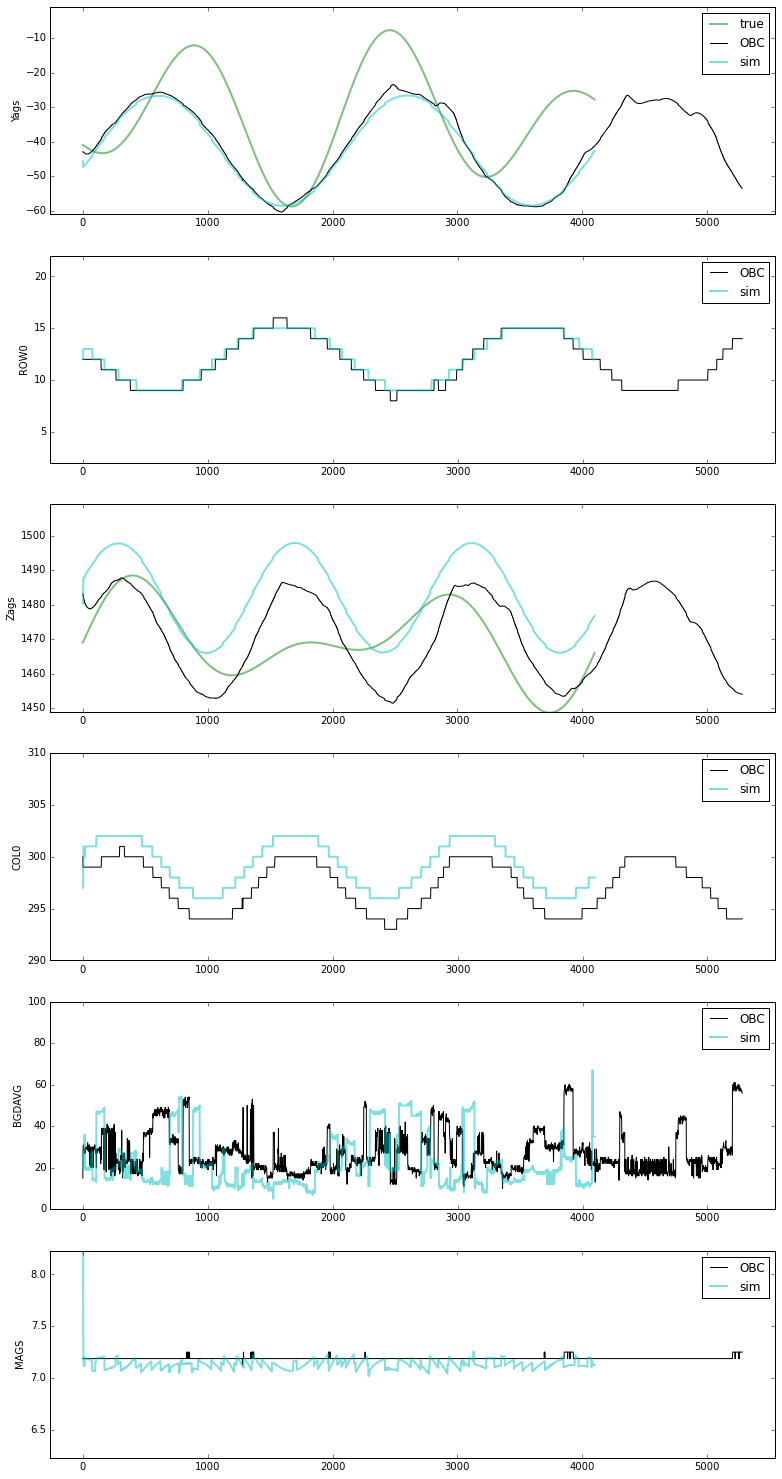

In [29]:
plot_guide_summary(guide, obc)

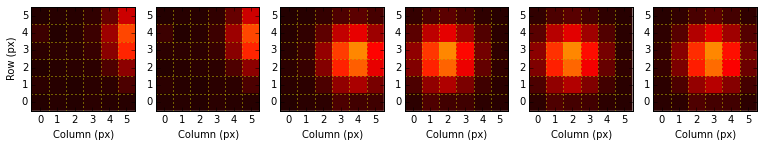

In [12]:
plt.figure(figsize=(13, 5))
start, num = 0, 6
plot_set(guide['imgraws'], start=start, num=num, vmin=-300, vmax=7000, grid6x6=True)

## Slot 6. Tracking hot pixel ##

In [31]:
slot = 6
yag, zag, mag, maxmag = get_telem(cat, slot)
yag, zag, mag, maxmag

(-164, -1661, 9.7720000000000002, 11.827999999999999)

In [32]:
obc = ObcAca(d.start, d.stop, slot=slot)

In [33]:
reload(sim)
kwargs = {'nframes': 2000, 'radius': 40., 'imgsize': 6, 'dither': dither, 'dark': '2017:092'}
guide = sim.simulate_guide(quat, yag, zag, mag, **kwargs)

({'dither_z_phase': 0.05, 'dither_y_phase': 0.45, 'dither_y_period': 2000.0, 'dither_z_amp': 16.0, 'dither_z_period': 1414.8, 'dither_y_amp': 16.0}, -164, -1661, <Quat q1=0.49949571 q2=-0.33350016 q3=-0.75700218 q4=0.25735068>)


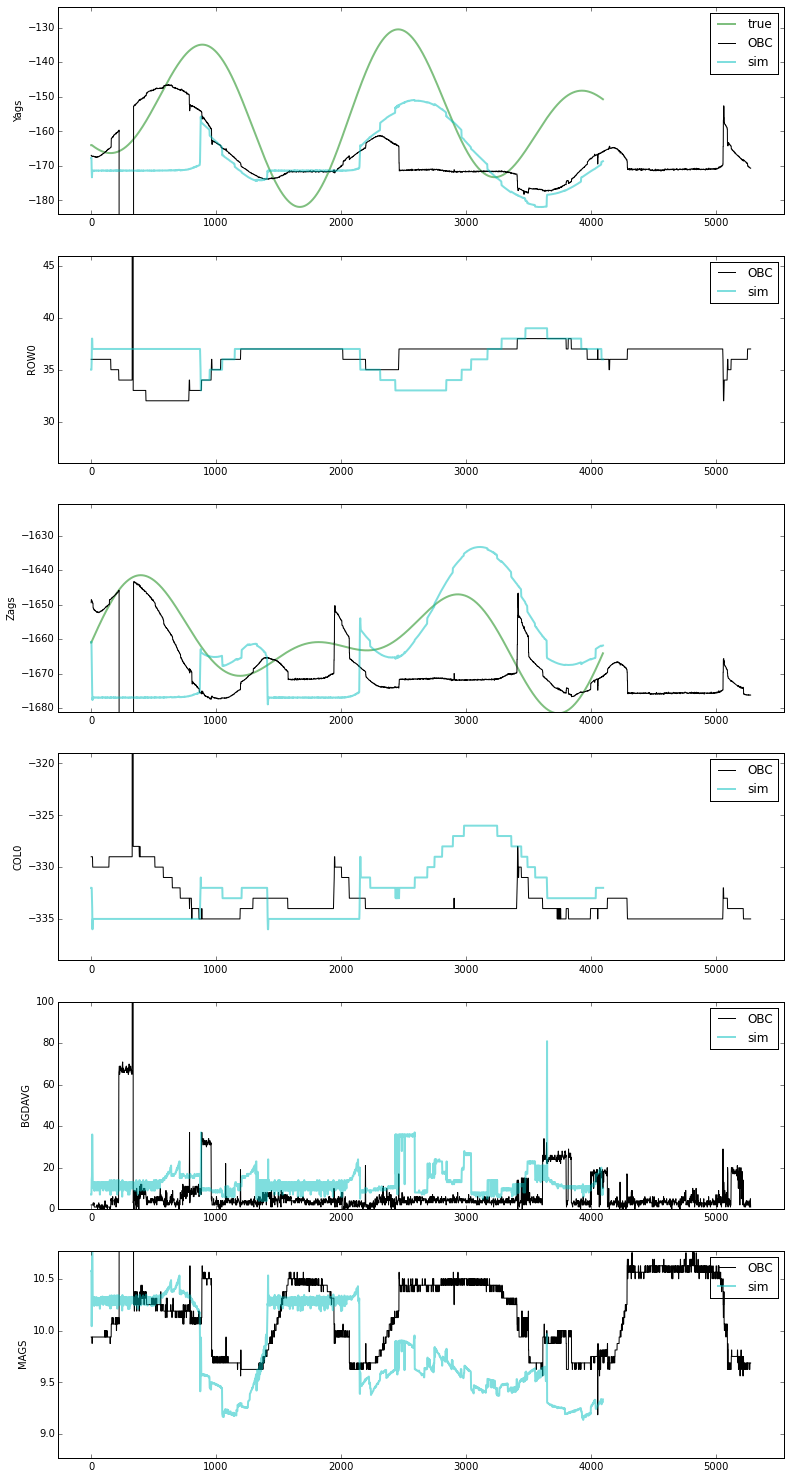

In [34]:
plot_guide_summary(guide, obc)

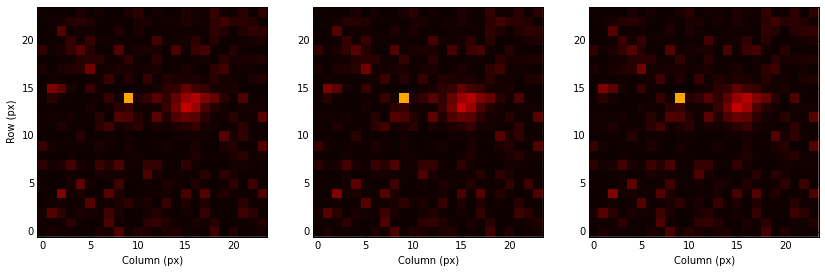

In [35]:
plt.figure(figsize=(14, 5))
start, num = 0, 3
plot_set(guide['stars'], start=start, num=num, vmax=1500)

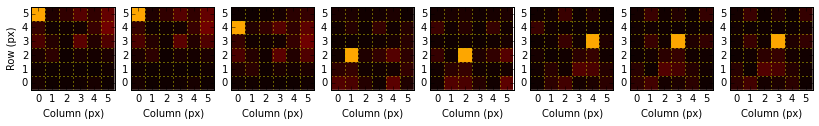

In [36]:
plt.figure(figsize=(14, 5))
start, num = 0, 8
plot_set(guide['imgraws'], start=start, vmax=1500, num=num, grid6x6=True)

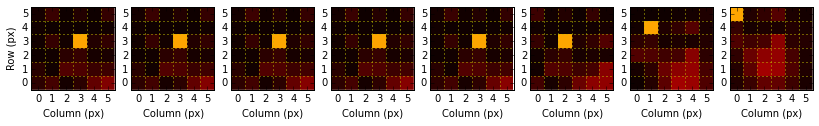

In [37]:
plt.figure(figsize=(14, 5))
start, num = 420, 8
plot_set(guide['imgraws'], start=start, vmax=1500, num=num, grid6x6=True)

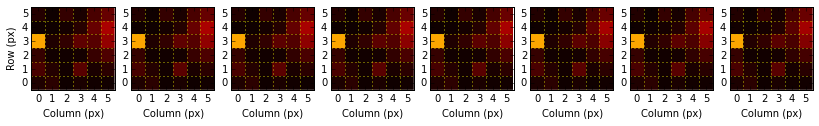

In [40]:
plt.figure(figsize=(14, 5))
start, num = 665, 8
plot_set(guide['imgraws'], start=start, vmax=1500, num=num, grid6x6=True)

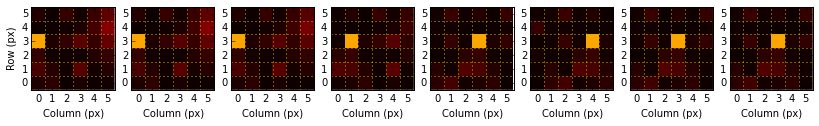

In [21]:
plt.figure(figsize=(14, 5))
start, num = 684, 8
plot_set(guide['imgraws'], start=start, vmax=1500, num=num, grid6x6=True)